In [1]:
# -*- coding: utf-8 -*- 

import numpy as np
import pandas as pd

from pathlib import Path

import nibabel as nib

import bids
from bids import BIDSLayout
from tqdm import tqdm

import nilearn as nil
from nilearn.plotting import plot_stat_map, show

import matplotlib.pyplot as plt

In [2]:
# information for path, hyperparams..
data_dir = '/home/mybirth0407/datasets/ds000005' # custom directory

In [3]:
bids.config.set_option('extension_initial_dot', True)
layout = BIDSLayout(data_dir, derivatives=True)

In [4]:
def make_contrasts(design_matrix):
    """ returns a dictionary of four contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])

    # Short dictionary of more relevant contrasts
    contrasts = {
        'risky': contrasts['risky'],
        'safe': contrasts['safe'],
        'risky-safe': contrasts['risky'] - contrasts['safe']
    }
    return contrasts

In [33]:
from nilearn import plotting

def plot_contrast(first_level_model):
    """ Given a first model, specify, estimate and plot the main contrasts"""
    
    design_matrix = first_level_model.design_matrices_[0]
    # Call the contrast specification within the function
    contrasts = make_contrasts(design_matrix)
    fig = plt.figure(figsize=(11, 3))
    
    z_maps = []
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        ax = plt.subplot(1, len(contrasts), 1 + index)
#         z_map = first_level_model.compute_contrast(contrast_val, output_type='z_score')
        z_map = first_level_model.compute_contrast([contrast_val * len(first_level_model.design_matrices_)], output_type='z_score')

        plotting.plot_stat_map(
            z_map, display_mode='z', threshold=3.0,
            title=contrast_id, axes=ax, cut_coords=1)
        z_maps.append(z_map)
    return z_maps

# Single subject, multiple run

In [6]:
subject_id = layout.get_subject()[0]

In [7]:
image_samples = layout.derivatives['fMRIPrep'].get(
    subject=subject_id,
    return_type='file',
    suffix='smoothed',
    extension='nii.gz')

event_samples = layout.get(
    subject=subject_id,
    return_type='file',
    suffix='events',
    extension='tsv')

In [8]:
df_events = []

for i, event_sample in enumerate(event_samples):
    df = pd.read_table(event_sample)
    df['subjID'] = subject_id
    df['run'] = i + 1
    df['respcat'] = df['respcat'].apply(lambda x: 1 if x == 1 else 0)
    df['onset'] = df['onset'].astype(np.int)
    df['cert'] = 0 # certain..?
    df['gamble'] = df['respcat']    
    df_events.append(df)

columns = df_events[0].columns.copy() # for safety
df_events[0].head()

,onset,duration,parametric loss,distance from indifference,parametric gain,gain,loss,PTval,respnum,respcat,response_time,subjID,run,cert,gamble
0,0,3,0.1273,-0.0814,-0.139,20,15,5.15,0,0,0.000,01,1,0,0
1,4,3,-0.0227,-0.4147,-0.189,18,12,6.12,2,1,1.793,01,1,0,1
2,8,3,0.1273,0.2519,-0.389,10,15,-4.85,3,0,1.637,01,1,0,0
3,18,3,0.1773,-0.0814,0.211,34,16,18.16,1,1,1.316,01,1,0,1
4,24,3,-0.3727,-0.0814,-0.189,18,5,13.05,1,1,1.670,01,1,0,1


In [9]:
model = ra_prospect(data=pd.concat(df_events), ncore=4)
print(model.all_ind_pars)
params = model.all_ind_pars
params.to_csv('models/ra_prospect_params_ss_mr.tsv', sep='\t', index=False)

In [10]:
params = pd.read_table('models/ra_prospect_params_ss_mr.tsv')
params['subjID'] = params.index + 1
params['subjID'] = params['subjID'].apply(lambda x: f'{x:02d}')

In [11]:
params.head()

,rho,lambda,tau,subjID
0,0.746932,1.03938,8.912809,01


In [ ]:
# calculate for utility risky
for i in range(len(df_events)):
    df_events[i]['trial_type'] = df_events[i]['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
df_events[i]['modulation'] = (df_events[i]['gain'] ** params['rho'].values[0]) - (params['lambda'].values[0] * (df_events[i]['loss'] ** params['rho'].values[0]))
df_events[i] = df_events[i][['onset', 'trial_type', 'duration', 'modulation']]

In [15]:
mc = [pd.read_table(confounds)[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']] \
          for confounds in layout.derivatives['fMRIPrep'].get(subject=subject_id, suffix='regressors', extension='.tsv')]

In [16]:
from nilearn.glm.first_level import FirstLevelModel

first_level_model = FirstLevelModel(layout.get_tr(), high_pass=.016, hrf_model='glover', noise_model='ols', smoothing_fwhm=6)
first_level_model = first_level_model.fit([nib.load(image_sample) for image_sample in image_samples], events=df_events, confounds=mc)

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")


In [210]:
# make mean design matrix
# design_matrix = pd.concat(first_level_model.design_matrices_)
# by_row_index = design_matrix.groupby(design_matrix.index)
# design_matrix = by_row_index.mean()

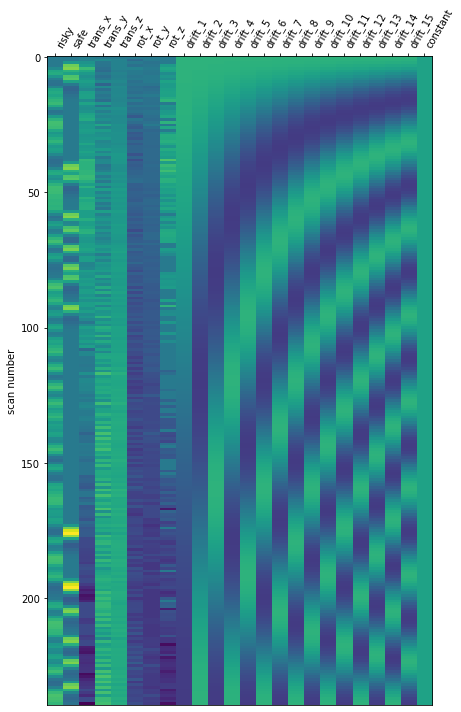

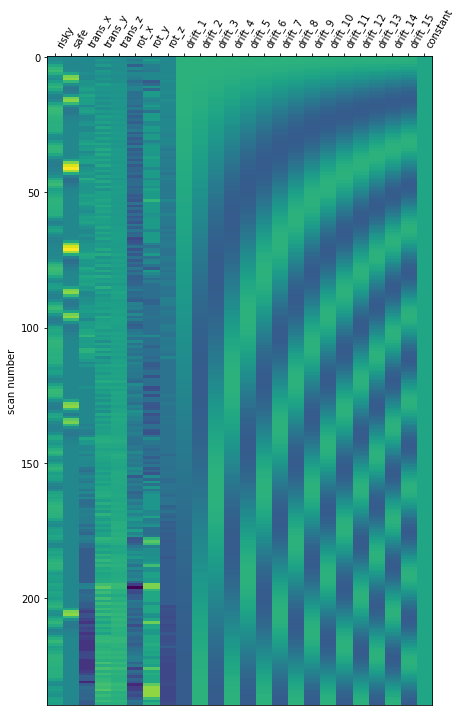

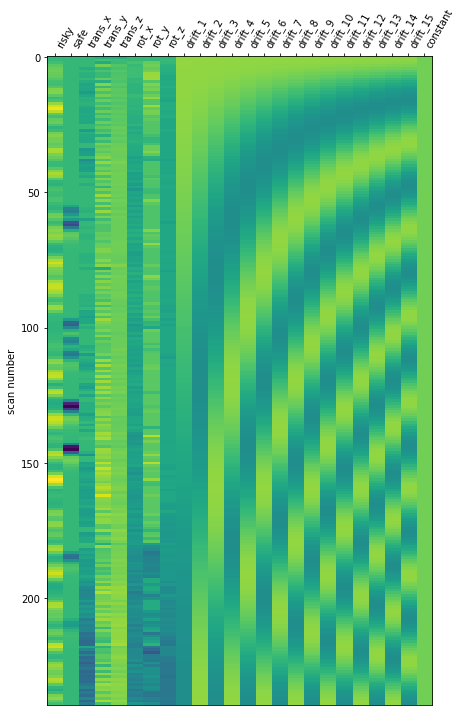

In [18]:
from nilearn.reporting import plot_design_matrix

for design_matrix in first_level_model.design_matrices_:
    plot_design_matrix(design_matrix)
    plt.show()

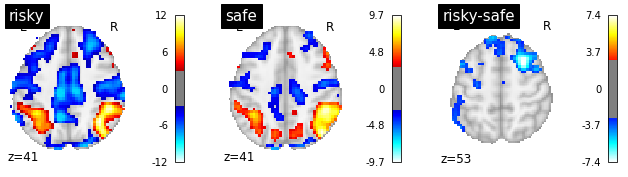

In [23]:
plot_contrast(first_level_model)
plt.show()

# Multiple subject, multiple run using bids format

In [24]:
from nilearn.glm.first_level import first_level_from_bids

models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
    data_dir, layout.get_task()[0], layout.get_space()[0], smoothing_fwhm=6.0, derivatives_folder='derivatives/fmriprep')

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:850: UserWarning: SliceTimingRef not found in file /home/mybirth0407/datasets/ds000005/derivatives/fmriprep/sub-01/func/sub-01_task-mixedgamblestask_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json. It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models
  img_specs[0])


In [27]:
# events file preprocessing

for i in range(len(models_events)):
    for j in range(len(models_events[i])):
        onsets = models_events[i][j]
        onsets['trial_type'] = onsets['respcat'].apply(lambda x: 'risky' if x == 1 else 'safe')
        onsets['modulation'] = (onsets['gain'] ** params['rho'].values[0]) - (params['lambda'].values[0] * (onsets['loss'] ** params['rho'].values[0]))
        onsets = onsets[['onset', 'trial_type', 'duration', 'modulation']]
        models_events[i][j] = onsets

In [28]:
# confounds file preprocessing

for i in range(len(models_confounds)):
    for j in range(len(models_confounds[i])):
        mc = models_confounds[i][j]
        mc = mc[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
        models_confounds[i][j] = mc

In [29]:
first_level_models = [models[i].fit([nib.load(run_img) for run_img in models_run_imgs[i]], events=models_events[i], confounds=models_confounds[i]) \
                          for i in tqdm(range(len(models)))]

  0%|          | 0/16 [00:00<?, ?it/s]/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
  6%|▋         | 1/16 [00:19<04:47, 19.14s/it]/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/experimental_paradigm.py:63: UserWarning: 'modulation' column fou

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:577: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


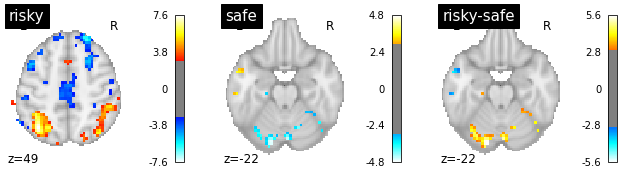

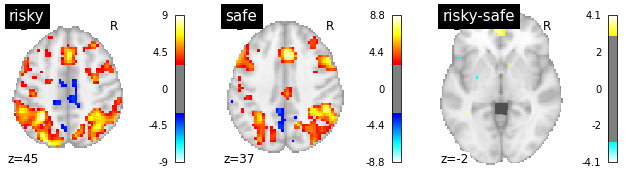

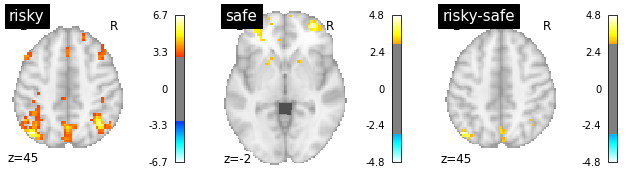

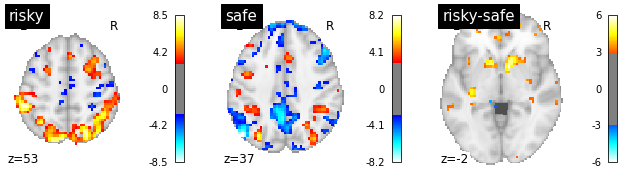

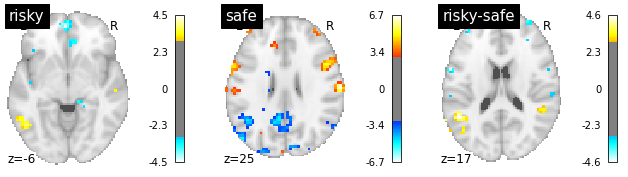

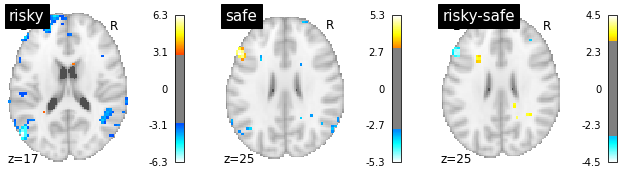

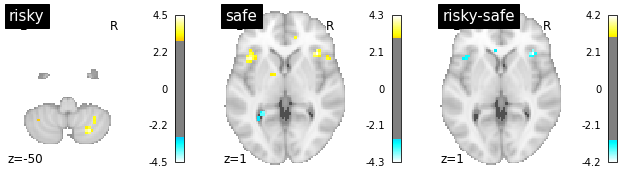

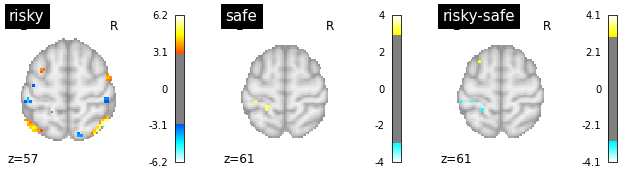

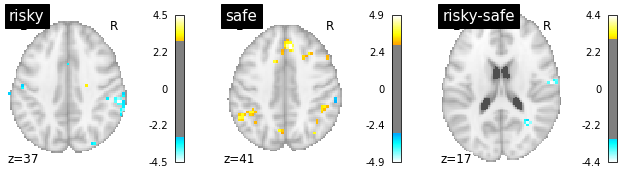

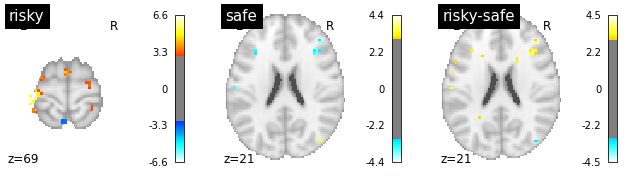

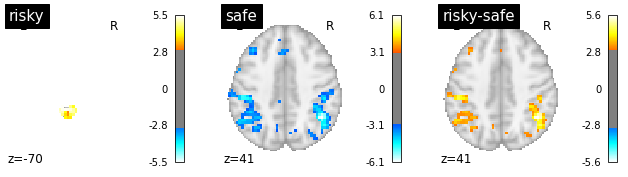

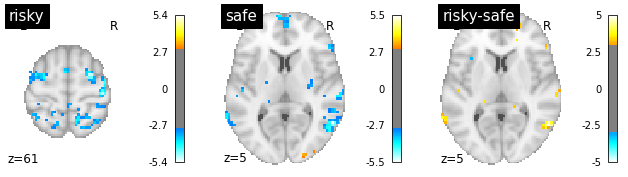

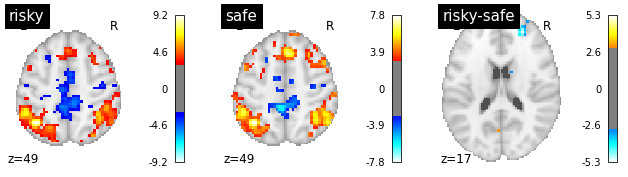

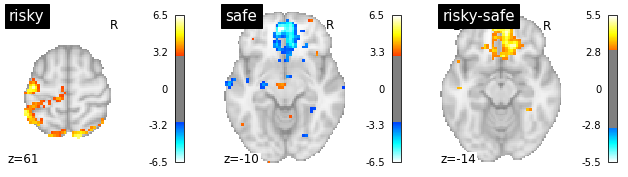

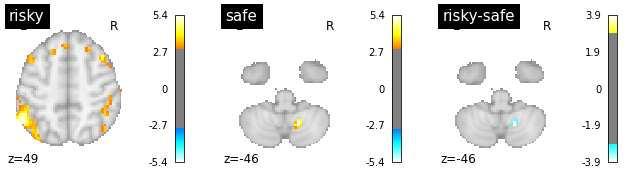

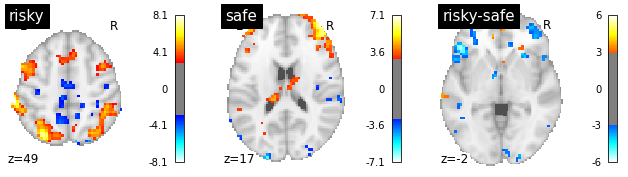

In [30]:
z_maps = []
for flm in first_level_models:
    z_maps.append(plot_contrast(flm))
    plt.show()

In [31]:
first_level_dir = Path('results/model_based_first_level')

import os
if not os.path.exists(first_level_dir):
    os.makedirs(first_level_dir)
    
for i, z_map in enumerate(z_maps):
    nib.save(z_map[2], first_level_dir / f'risky_safe_subject_{i+1:02d}.nii') # z_map[0] is riksy, z_map[1] is safe, z_map[2] is risky-safe

In [32]:
first_level_dir = Path('results/model_based_first_level')

import os
if not os.path.exists(first_level_dir):
    os.makedirs(first_level_dir)
    
for i, z_map in enumerate(z_maps):
    nib.save(z_map[2], first_level_dir / f'risky_subject_{i+1:02d}.nii') # z_map[0] is riksy, z_map[1] is safe, z_map[2] is risky-safe

# Second level analysis using GLM (required result image of first level analysis using GLM)

In [ ]:
# TODO

In [ ]:
second_level_input = [z_map[2] for z_map in z_maps]
design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

In [ ]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(smoothing_fwhm=6.0)
second_level_model = second_level_model.fit(second_level_input,
                                            design_matrix=design_matrix)